In [3]:
from hac import GreedyAgglomerativeClusterer
import networkx as nx
import matplotlib.pyplot as plt 
import math
import pandas as pd
import xlrd
%matplotlib inline

In [2]:
def edges_list(graph_list):
    test_list=[]
    test_j_list = []
    for i in graph_list:
        test_j_list.append(i)

    for i in range(len(test_j_list)):
        for j in range(i+1,len(test_j_list)):
            k = test_j_list[i]
            j = test_j_list[j]
            a = (k,j)
            test_list.append(a)
            
    return test_list

In [4]:
stock_300 = xlrd.open_workbook("F:/项目/复杂网络/数据预处理_前复权/300SS.xlsx")
stock_sheet = stock_300.sheets()[0]

In [6]:
stock_list_nodict = []##将股票数据存为一个list，去掉时间和股票代号
for i in range(1,301):
    stock_list_nodict.append(stock_sheet.col_values(i)[1:287])

## 需要对线性相关系数进行改进
### 用移动平均线作出股票的趋势图，对每个时点，求两支股票趋势图的斜率（增量）乘积，若两支股票有很好的联动性，趋势同增同减，则乘积为正，否则为负
### 乘积在时段上求和，如果联动性不明显，则乘积有正有负，正负相消接近0；如果联动性明显，则会得到很大的正值
### 对天数求平均，得到联动相关性系数
$$ r_{ij}  = \frac{1}{T}\sum_{t=1}^{T-1}[\frac{p_{i}(t+1)-p_{i}(t)}{p_{i}(t)}\cdot \frac{p_{j}(t+1)-p_{j}(t)}{p_{j}(t)}]$$

In [7]:
#定义联动相关系数
def der_correlative(list1,list2,t=1):
    T = len(list1)
    sum_pq = 0
    for i in range(len(list1)-1):
        p = (list1[i+t]-list1[i])/list1[i]
        q = (list2[i+t]-list2[i])/list2[i]
        p_q = p*q
        sum_pq += p_q
    r_pq = sum_pq/T
    return r_pq*1000

## 此外，我们将日收盘价替代为三天移动平均价格，选择3天是因为这个趋势线相对地光滑而且更有效地处理数据，即
$$p_{i} = (p_{i} +p_{i} +p_{i+1} )/3$$
## 为了处理数据方便，我们将所有数据乘以$10^{3}$

In [9]:
stock_moving_list = []
for i in range(len(stock_list_nodict)):
    stock_inside_list = []
    for j in range(1,len(stock_list_nodict[i])-1):
        a = (stock_list_nodict[i][j-1]+stock_list_nodict[i][j]+stock_list_nodict[i][j+1])/3
        stock_inside_list.append(a)
    
    stock_moving_list.append(stock_inside_list)

In [10]:
cor_list = []
for i in range(300):
    for j in range(i+1,300):
        cor_list.append(der_correlative(stock_moving_list[i],stock_moving_list[j]))#计算联动相关性系数

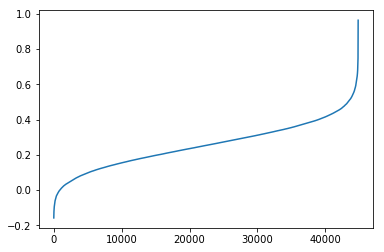

In [11]:
cor_list.sort()
plt.plot(cor_list)

(array([  2.74000000e+02,   2.90900000e+03,   9.52400000e+03,
          1.46870000e+04,   1.18070000e+04,   4.46700000e+03,
          9.80000000e+02,   1.77000000e+02,   2.20000000e+01,
          3.00000000e+00]),
 array([-0.15750082, -0.04538417,  0.06673248,  0.17884913,  0.29096578,
         0.40308243,  0.51519909,  0.62731574,  0.73943239,  0.85154904,
         0.96366569]),
 <a list of 10 Patch objects>)

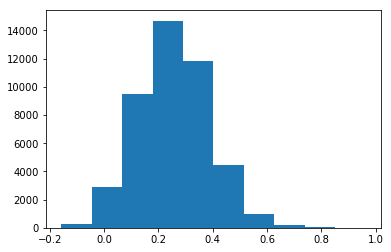

In [12]:
plt.hist(cor_list)

In [13]:
network_list1 = []
for i in range(1,301):
    for j in range(i+1,301):
        network_list1.append(tuple([i,j]))#加入标识
        network_list1.append(der_correlative(stock_moving_list[i-1],stock_moving_list[j-1]))#加入改进后的相关系数值

In [14]:
network_list_cut1  =[]
for i in network_list1:
    network_list_cut1.append(i)

In [15]:
for i in range(1,len(network_list_cut1),2):
    if network_list_cut1[i]<0.45 :#小于0.45的都剔除
        network_list1.remove(network_list_cut1[i-1])
        network_list1.remove(network_list_cut1[i])

In [16]:
node_init_list = []
for i in range(0,len(network_list1)-1,2):
    x,y = network_list1[i]
    node_init_list.append(x)
    node_init_list.append(y)

In [17]:
# 去除node_init_list中的重复的元素
node_list = []
for i in node_init_list:
    if i not in node_list:
        node_list.append(i)

In [18]:
len(node_list)

180

In [19]:
network_stock1 = nx.Graph()
network_stock1.add_nodes_from(node_list)
network_stock1.add_edges_from([network_list1[i] for i in range(0,len(network_list1),2)])

E:\anconda\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
E:\anconda\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
E:\anconda\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
E:\anconda\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


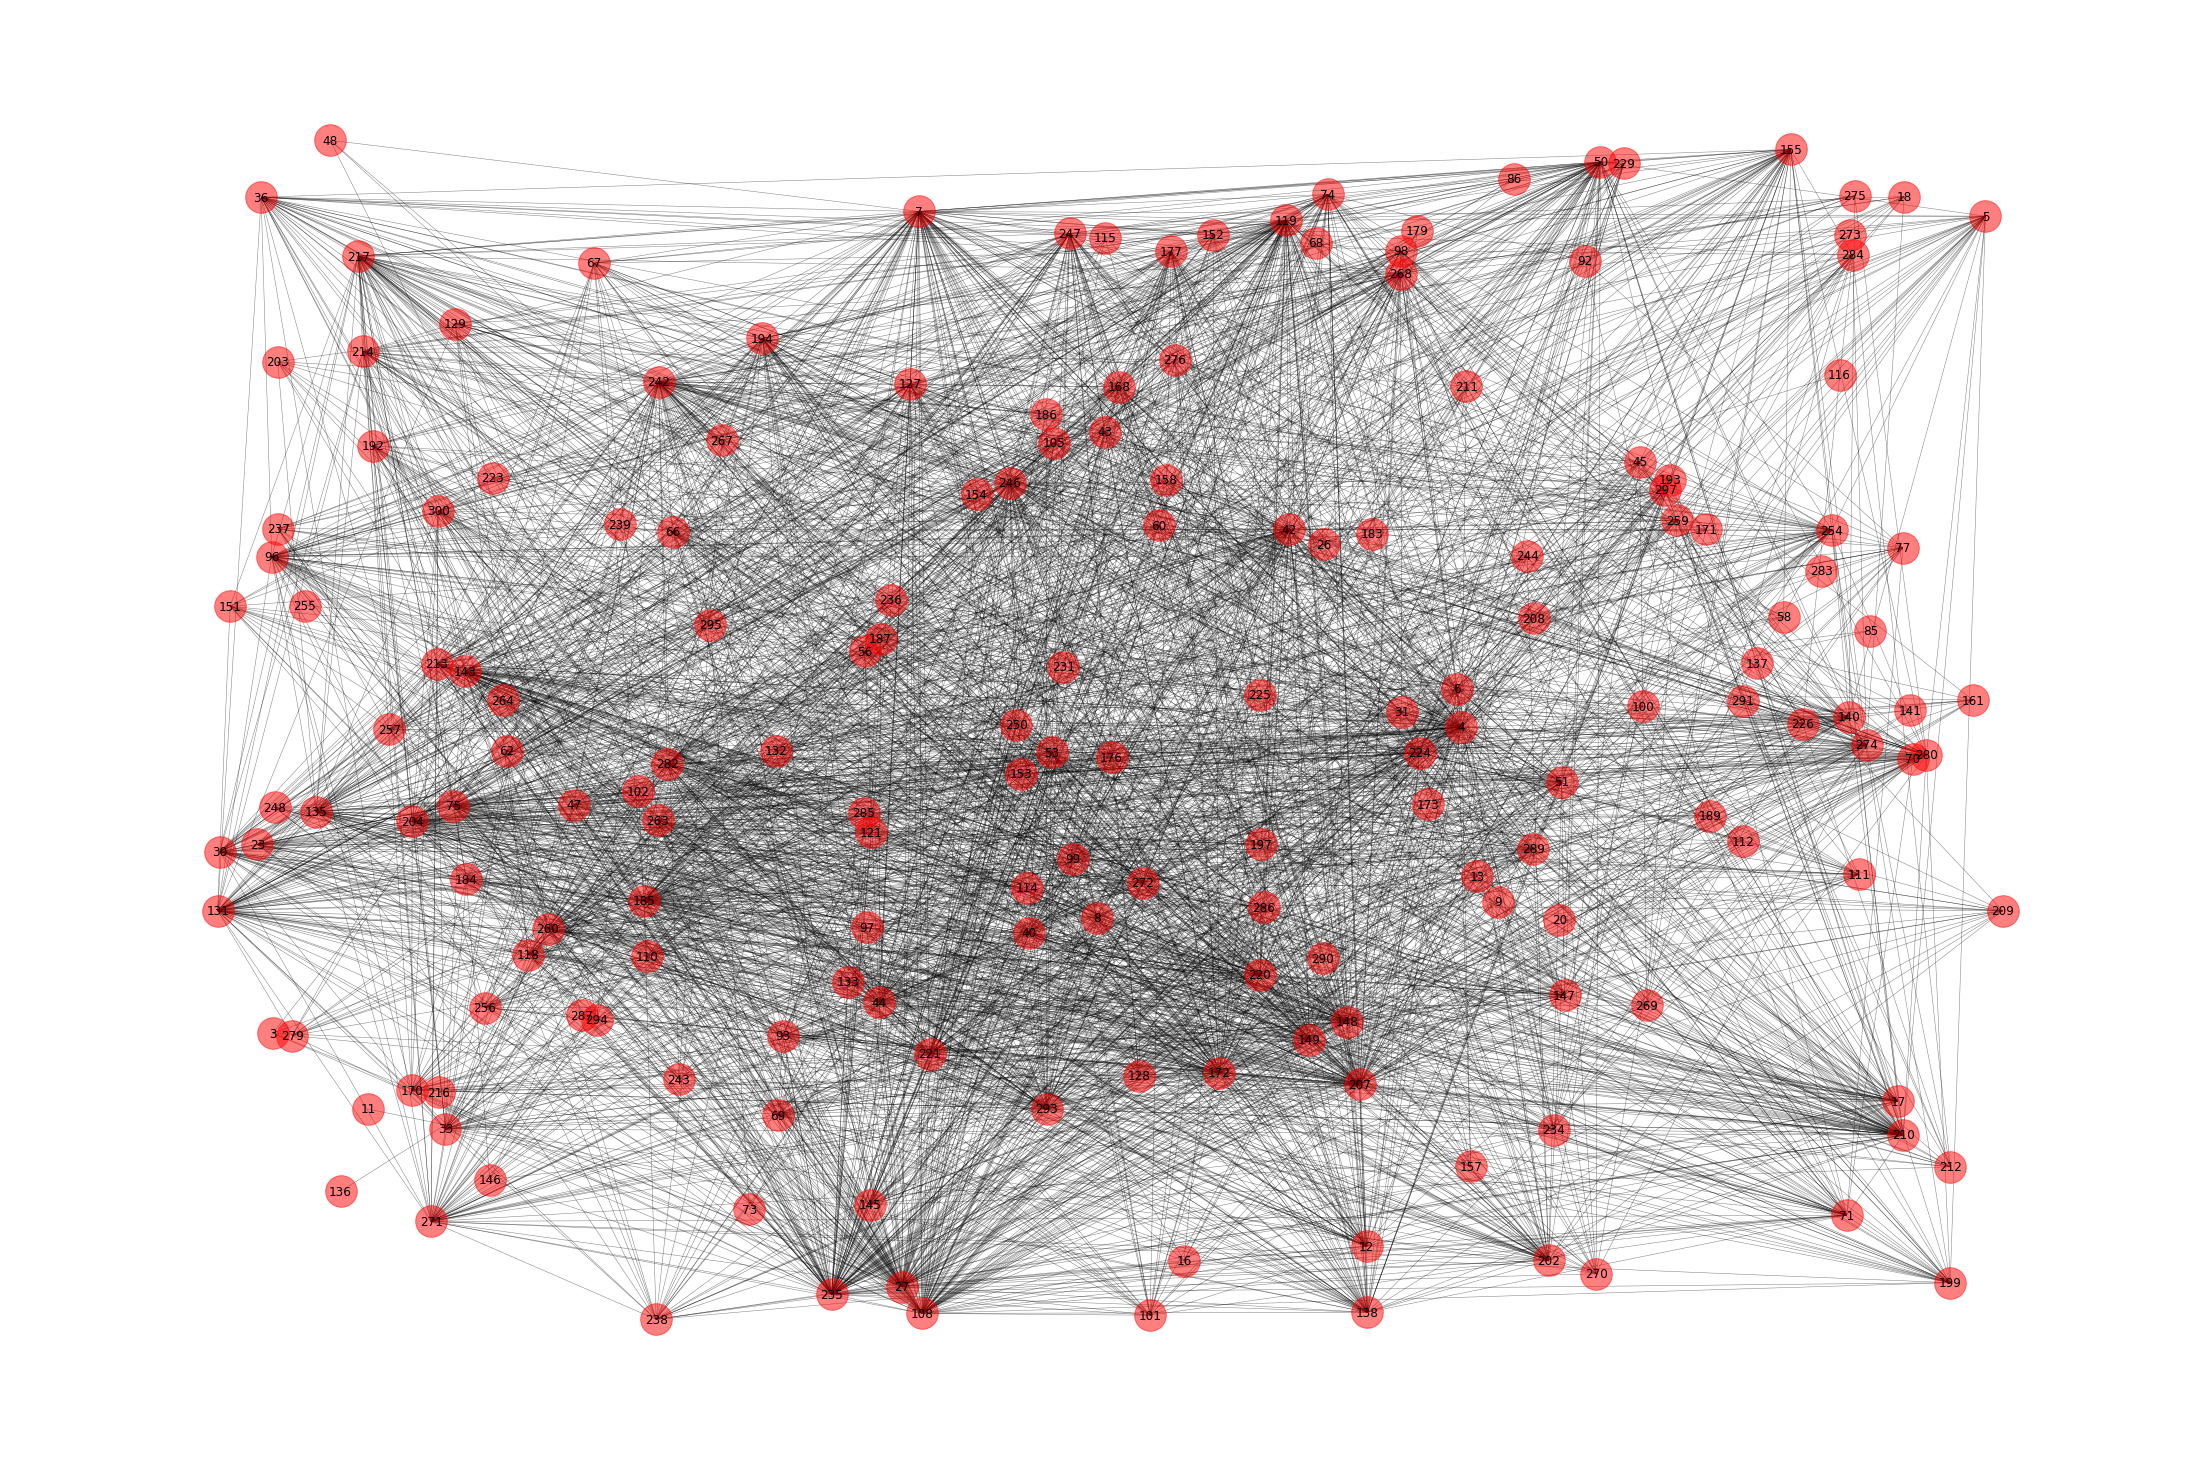

In [20]:
#network_stock.remove_node(64)
pos=nx.spring_layout(network_stock1)
nx.draw_random(network_stock1,with_labels=True,node_size=1000,alpha=0.5,node_color='r',width=0.5,edge_cmap=plt.cm.Blues,edge_vmin=2,edge_vmax=3)
#plt.savefig("test2.png") # save as png
fig = plt.gcf()
fig.set_size_inches(30, 20)
plt.show()

## Q值的计算
### 衡量网络模块化的指标Q值
#### 设网络为$N=(V,E),P_{k}={(V_{1},E_{1}),(V_{2},E_{2}),...,(V_{k},E_{k})}$为一个分划
#### $E_{ij}$表示网络中连接两个不同社区点的边在所有边中所占的比例，这两点节点分别位于第i个社区和第j个社区。
#### 定义每行（或者列）中各元素之和为$a_{i} = \sum_{j} E_{ij}$
#### Newman和Girvan提出一种衡量网络社区结构的指标Q值
$$Q = \sum_{i}(E_{ij}-a_{i}^{2}) = Tr(E)-||E^{2}||$$

## 聚集系数
### 一个节点的聚类系数是这个节点讯在的连接点数与最大可能的连接点数的比值，一个网络整体的聚类系数是各个节点聚类系数的取平均值。

In [26]:
clusterer = GreedyAgglomerativeClusterer()
network_fast1 = clusterer.cluster(network_stock1)

In [21]:
nx.clustering(network_stock1)

{3: 1.0,
 4: 0.33539944903581265,
 5: 0.9001782531194296,
 6: 0.6321321321321322,
 7: 0.39600448095593727,
 8: 0.9556451612903226,
 9: 1.0,
 11: 0.0,
 12: 0.6152882205513784,
 13: 0.9818181818181818,
 16: 0.9722222222222222,
 17: 0.8393234672304439,
 18: 0.7636363636363637,
 20: 1.0,
 23: 0.7428571428571429,
 26: 0.6571428571428571,
 27: 0.37545787545787546,
 30: 0.7571644042232277,
 31: 0.7566137566137566,
 33: 0.7363945578231292,
 36: 0.6045883940620783,
 40: 0.6095791001451378,
 42: 0.44072164948453607,
 43: 0.6543385490753911,
 44: 0.5951293759512938,
 45: 0.84,
 47: 0.7891737891737892,
 48: 1.0,
 50: 0.5938541281007035,
 51: 0.702865761689291,
 53: 0.6274801587301587,
 56: 0.9633333333333334,
 58: 1.0,
 60: 0.9122807017543859,
 62: 0.9411764705882353,
 66: 0.8873873873873874,
 67: 0.9107692307692308,
 68: 1.0,
 69: 0.7564102564102564,
 70: 0.9615384615384616,
 71: 0.7536585365853659,
 73: 1.0,
 74: 0.5746606334841629,
 75: 0.4578577699736611,
 77: 0.7894736842105263,
 85: 1.0,
 86

In [22]:
nx.average_clustering(network_stock1)

0.7509111607261525

In [23]:
def Q1(comm,G):
    edges=G.edges()
    m=len(edges)
    #每个节点的度
    du=G.degree()
    #通过节点对（同一个社区内的节点对）计算
    ret=0.0
    for c in comm:
        for x in c:
            for y in c:
                #边都是前小后大的
                #不能交换x，y，因为都是循环变量
                if x<=y:
                    if (x,y) in edges:
                        aij=1.0
                    else:
                        aij=0.0
                else:
                    if (y,x) in edges:
                        aij=1.0
                    else:
                        aij=0
                tmp=aij-du[x]*du[y]*1.0/(2*m)
                ret=ret+tmp
    ret=ret*1.0/(2*m)
    return ret

In [24]:
def set_to_list(clusters):#将数据结构set转化为list
    network_clusters=[]
    for i in clusters:
        tt = list(i)
        tt.sort()
        network_clusters.append(tt)
    return network_clusters

In [27]:
q_values = []
for i in range(1,181):
    q_values.append(Q1(set_to_list(network_fast1.clusters(i)),network_stock1))

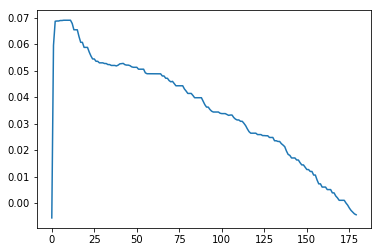

In [28]:
plt.plot(q_values)

In [29]:
#选取这个社团节点之间的边
test_comm = []
for i in network_fast1.clusters(11)[2]:
    for j in network_fast1.clusters(11)[2]:
        for k in network_stock1.edges():
            if (i,j) == k:
                test_comm.append((i,j))

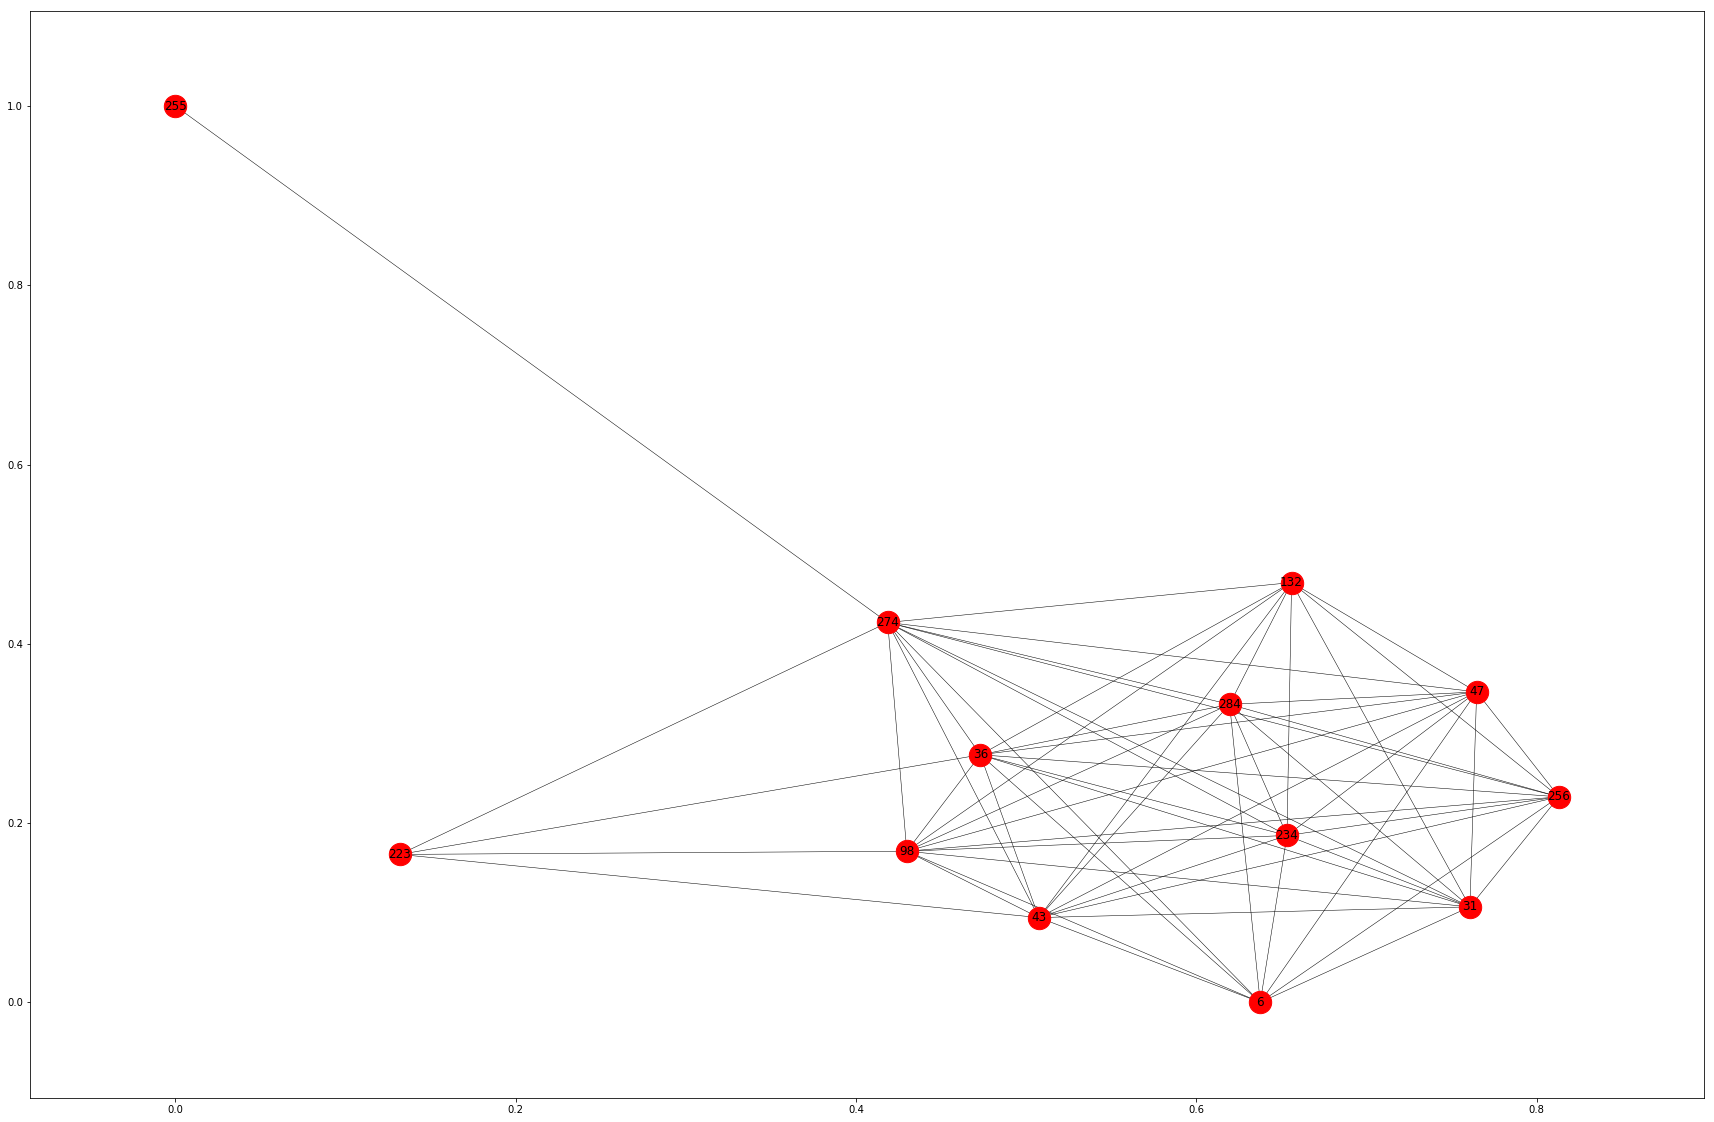

In [30]:
comm = nx.Graph()
comm.add_nodes_from(list(list(network_fast1.clusters(11)[2])))
comm.add_edges_from(test_comm)
nx.draw_networkx(comm,with_labels=True,node_size=500,alpha=1,node_color='r',width=0.5)#,edge_vmin=5,edge_vmax=10
#plt.savefig("test2.png") # save as png
fig = plt.gcf()
fig.set_size_inches(30, 20)
plt.show()

In [31]:
couu_1 = list(network_fast1.clusters(11)[2])
couu_1.remove(223)
couu_1.remove(255)
print(couu_1)

[256, 98, 36, 132, 6, 234, 43, 47, 274, 284, 31]


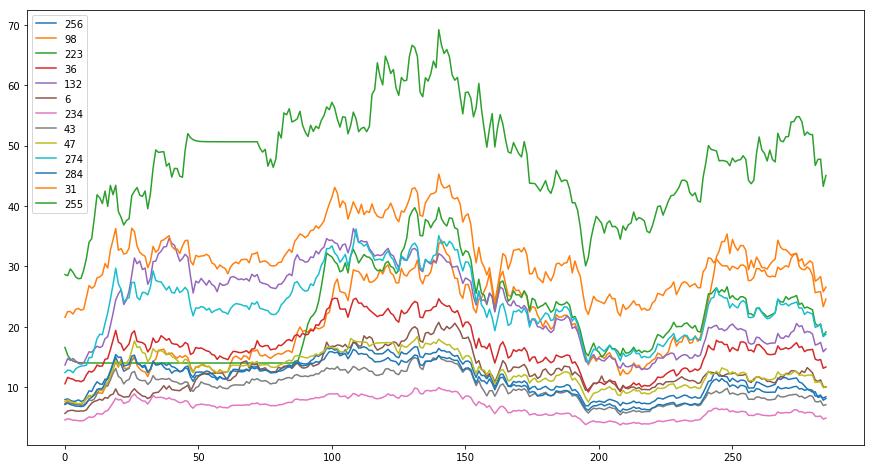

In [32]:
plt.figure(figsize=(15,8))
for i in list(network_fast1.clusters(11)[2]):
    j = i-1
    plt.plot(stock_list_nodict[j],label = i)

plt.legend(loc = 'upper left')
plt.show()